# Upbit API를 이용한 데이터 수집
3초마다 200개의 자료를 수집하여 저장

In [1]:
from datetime import datetime
import pandas as pd
import json

# json to DataFrame
def resToDF(json_text):
    contents = json.loads(json_text)
    contents = pd.DataFrame(contents,columns=[
                                'candle_date_time_kst','opening_price','high_price','low_price',
                                'trade_price','candle_acc_trade_volume','candle_acc_trade_price'])
    contents = contents.set_index('candle_date_time_kst')
    contents.index=pd.to_datetime(contents.index)
    return contents

def get_line_time(file_name, line_number):
    try: 
        with open(file_name, "r") as f:
            line = f.readlines()[line_number].strip().split(",")
            return datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
    except ValueError:
        print("empty file:", file_name)
        return datetime.now()

In [2]:
from modules.local_values import tickers, raw_folder
import os
if os.path.exists(raw_folder)==False:
    os.makedirs(raw_folder)

for tick in tickers:
    file_name=raw_folder+tick+'.csv'
    if os.path.exists(file_name)==False:
        with open(file_name,'w') as file:
            file.write(",open,high,low,close,volume,value\n")

In [3]:
from datetime import timedelta
import requests
import time

count=200
headers = {"accept": "application/json"}
for tick in tickers:
    file_name=raw_folder+tick+'.csv'
    url=f'https://api.upbit.com/v1/candles/minutes/1?market={tick}&count={count}&to='
    tick_len=0
    to_time = get_line_time(file_name,-1)

    while True:
        to_time=(to_time-timedelta(hours=9)).strftime('%Y-%m-%dT%H:%M:%S')
        response=requests.get(url+to_time, headers=headers)
        contents=resToDF(response.text)
        time.sleep(3)
        if contents.shape[0] != 200:
            print(f'{tick} updates ~ {to_time} = {tick_len} length')
            break
        to_time=contents.index[-1]
        contents.to_csv(file_name,mode='a',header=False)
        tick_len += contents.shape[0]

KRW-BTC updates ~ 2017-09-25T13:34:00 = 0 length
KRW-ETH updates ~ 2017-09-25T20:51:00 = 0 length
KRW-XRP updates ~ 2017-09-25T17:37:00 = 0 length
KRW-SOL updates ~ 2021-10-15T09:29:00 = 0 length
KRW-AVAX updates ~ 2022-02-08T12:24:00 = 0 length
KRW-DOGE updates ~ 2021-02-24T08:55:00 = 0 length
KRW-ETC updates ~ 2017-09-25T14:08:00 = 0 length


### Data 파악
|index|open|high|low|close|volume|value|
|-----|----|----|---|-----|------|-----|
|UTC 기준|시가|고가|저가|종가|누적 거래량|누적 거래금액|

In [4]:
from modules.local_values import tickers, raw_datas
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pd.set_option('float_format', '{:.2f}'.format)
df = pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df.describe()

,open,high,low,close,volume,value
count,3212000.00,3212000.00,3212000.00,3212000.00,3212000.00,3212000.00
mean,25943642.43,25957607.07,25929553.22,25943546.46,5.76,148888795.46
std,19557573.06,19568109.42,19546971.86,19557465.88,10.93,317117784.89
min,3565000.00,3568000.00,3562000.00,3565000.00,0.00,0.04
25%,9425000.00,9431000.00,9420000.00,9425000.00,0.95,14317637.90
50%,20024000.00,20040000.00,20004500.00,20024000.00,2.53,48920385.92
75%,38820000.00,38838000.00,38803000.00,38820000.00,6.08,151583847.72
max,82690000.00,82700000.00,82619000.00,82699000.00,718.86,25166633419.86


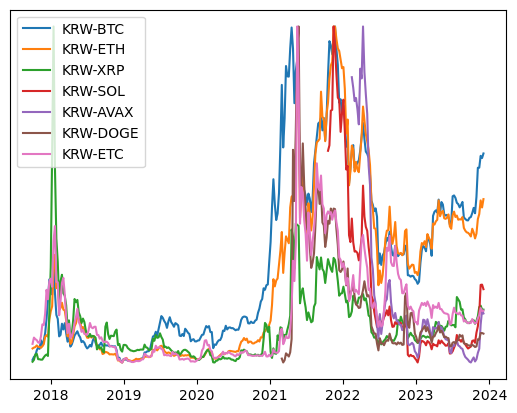

In [6]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='W').first()
    df_min_max=df['close']-df['close'].min()
    df_min_max=df_min_max/df_min_max.max()
    plt.plot(df_min_max,label=tick)

plt.yticks([],[])
plt.legend()
plt.show()

### 결측 데이터 확인
NaN 값 확인

In [7]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='T').first()
    msg='Data{:>9}\tTotal:{:>8}\t NaN:{:7}' \
        .format(tick,len(df),df['open'].isnull().sum())
    print(msg)

Data  KRW-BTC	Total: 3249992	 NaN:  37992
Data  KRW-ETH	Total: 3250422	 NaN: 186022
Data  KRW-XRP	Total: 3251443	 NaN: 200843
Data  KRW-SOL	Total: 1120114	 NaN:  37714
Data KRW-AVAX	Total:  953191	 NaN: 234591
Data KRW-DOGE	Total: 1456154	 NaN:  33554
Data  KRW-ETC	Total: 3253345	 NaN: 850145


#### KRW-BTC를 대표로 확인

In [8]:
df = pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df['diff']=df.index.to_series().diff().dt.total_seconds()/-60-1
df[df['diff']>0]['diff'].value_counts().sort_index()

diff
1.00      18483
2.00       2438
3.00        648
4.00        172
5.00         75
          ...  
267.00        1
280.00        1
288.00        1
357.00        1
475.00        1
Name: count, Length: 94, dtype: int64

In [9]:
print(df[df['diff']>0]['diff'].count())
print(df[df['diff']>20]['diff'].count())

22022
104


확인해 봤을 때, 1분간 거래가 없었던 경우는 꽤 흔하게 나타났다.   
그에 따라 한 10분까지는 거래가 없었을 수 있다고 본다.